In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
np.array([[1,2],[1,3]])[0]

array([1, 2])

In [2]:
df = pd.read_csv("info.txt", delimiter=" ")
df["filename"] = "files/" + df.REFNUM +".png"


In [3]:
X = []
y = []
images = []
for x in df[~df["SEVERITY"].isnull()].iterrows():
    img_array = cv2.imread(x[1]["filename"],cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    which = lambda t: 1 if t=="B" else 0
    #images[1] = images.get(1,[]) + [img]
    images.append([new_img_array,which(x[1]["SEVERITY"])])

In [4]:
for angle in range(360):
    for x in images:
        M = cv2.getRotationMatrix2D((80 / 2, 80 / 2), angle, 1)    #Rotate 0 degree
        img_rotated = cv2.warpAffine(x[0], M, (80, 80))
        #plt.imshow(img_rotated)
        X.append(img_rotated)
        which = lambda t: 1 if t=="B" else 0
        y.append(x[1])

In [5]:
import numpy as np
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
df = df.dropna(subset=["SEVERITY"])
train_df = df.loc[:len(df)*.6-1]
validation_df = df.loc[len(df)*.6:]
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col = 'filename',
        y_col = 'SEVERITY',
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col = 'filename',
        y_col = 'SEVERITY',
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 21 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


In [12]:
import tensorflow as tf
"""num_classes = 2
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (80 , 80 , 1), activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Conv2D(128 , (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5, seed = 5),
    tf.keras.layers.Dense(128 , activation = 'relu'),
    tf.keras.layers.Dense(num_classes , activation = 'softmax')])"""

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten


model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=(rows, cols, 1)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(32, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
#     model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1),input_shape=(80,80,1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 78, 78, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)       

In [13]:
model.compile(loss = 'binary_crossentropy' , optimizer = tf.keras.optimizers.Adam(lr = 0.001) , metrics = 'accuracy')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 78, 78, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)       

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
886/886 [==============================] - 184s 206ms/step - loss: 0.3527 - accuracy: 0.8567 - val_loss: 0.2205 - val_accuracy: 0.9078
Epoch 2/10
886/886 [==============================] - 207s 234ms/step - loss: 0.2456 - accuracy: 0.8975 - val_loss: 0.1969 - val_accuracy: 0.9162
Epoch 3/10
886/886 [==============================] - 224s 253ms/step - loss: 0.2191 - accuracy: 0.9052 - val_loss: 0.1614 - val_accuracy: 0.9349
Epoch 4/10
886/886 [==============================] - 201s 226ms/step - loss: 0.1963 - accuracy: 0.9202 - val_loss: 0.1468 - val_accuracy: 0.9421
Epoch 5/10
886/886 [==============================] - 205s 232ms/step - loss: 0.1903 - accuracy: 0.9229 - val_loss: 0.1415 - val_accuracy: 0.9400
Epoch 6/10
886/886 [==============================] - 6073s 7s/step - loss: 0.1724 - accuracy: 0.9306 - val_loss: 0.1326 - val_accuracy: 0.9459
Epoch 7/10
886/886 [==============================] - 252s 285ms/step - loss: 0.1582 - accuracy: 0.9367 - val_loss: 0.1132 - v

In [21]:
model.save("breast-cancer")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2289: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1376: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: breast-cancer/assets


In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)
def prediction(test_path):
    img = image.load_img(test_path , target_size = (300 , 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/300.0
        
    plt.title('Image')
    plt.axis('off')
    plt.imshow(img.squeeze())
        
    predict = model.predict(img[np.newaxis , ...])
    predicted_class = labels[np.argmax(predict[0] , axis = -1)]
        
    print('Prediction Value: ' , np.max(predict[0] , axis = -1))
    print("Classified:",predicted_class)

{0: 'B', 1: 'M'}


Prediction Value:  0.50030315
Classified: M


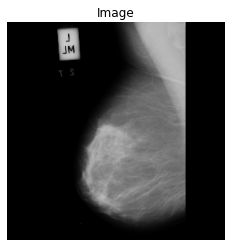

In [31]:
prediction(validation_df.iloc[7].filename)

In [32]:
validation_df.iloc[7]

REFNUM                  mdb095
BG                           F
CLASS                     ASYM
SEVERITY                     M
X                          466
Y                          517
RADIUS                      29
Unnamed: 7                 NaN
filename      files/mdb095.png
Name: 95, dtype: object